# Recovering statistics from edge-sampled networks

In this notebook we will investigate empirically how different statistics behave on networks that are edge-sampled, without any temporal analysis for the moment

In [154]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import random
import math

from collections import Counter
a4_dims = (11.69,8.27)
from scipy.stats import poisson
from scipy.stats import ks_2samp
import seaborn as sns

Simple function which returns from a given networkx graph G a graph H, the induced subgraph from a random proportion p of H's edges.

In [2]:
def edge_sample(G, p, seed=None):
    edges = G.edges()
    sampled=[]
    if seed is not None:
        random.Seed(seed)
    for e in edges:
        r = random.random()
        if r < p:
            sampled.append(e)
    H = nx.Graph()
    H.add_edges_from(sampled)
    return H

def get_deg_cdf(G):
    cts = Counter(sorted([d for n, d in G.degree()]))
    degs = sorted(cts.keys())
    vals = [cts[val] for val in degs]
    cdf = np.cumsum(vals)
    ccdf = cdf[-1] - cdf
    return degs, cdf

def count2freq(arr):
    counter = Counter(arr)
    tot = sum(counter.values())
    for k in counter:
        counter[k]/=tot
    return counter

def ecdf(a):
    x, counts = np.unique(a, return_counts=True)
    cusum = np.cumsum(counts)
    return x, cusum

In [3]:
def setup_axes(x,y,xscale="linear",yscale="linear"):
    fig, ax = plt.subplots(figsize = a4_dims)
    ax.set_xlabel(x,fontsize=20)
    ax.tick_params(axis='x', labelsize=16)
    ax.set_ylabel(y, fontsize=20)
    ax.set_xscale(xscale)
    ax.set_yscale(yscale)
    return fig, ax

In [4]:
#G = nx.gnp_random_graph(1000, 0.005)
G = nx.barabasi_albert_graph(10000,3)
n = len(G.nodes())
m = len(G.edges())
k = 2*m/n
print(m)

29991


## Degree distributions of sampled graphs

From the graph we just defined, we are interested in what the degree distributions of the sampled graphs look like, for varying sample probabilities p

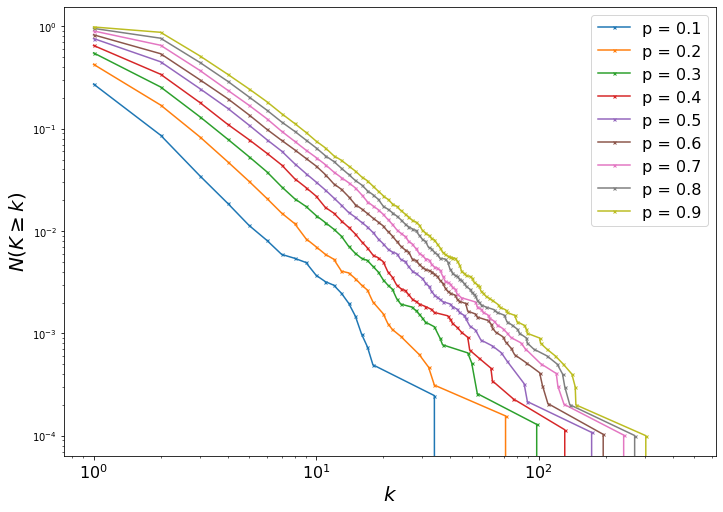

In [5]:
prange = np.linspace(0.1,0.9,9)
edges = G.edges()

fig, ax = setup_axes('$k$','$N(K\\geq k)$','log','log')

for p in prange:
    H = edge_sample(G,p)
    degs, cdf = get_deg_cdf(H)
    ccdf = 1-cdf/cdf[-1]
    ax.plot(degs, ccdf,marker='x',markersize=3,label="p = "+str(round(p,1)))
    
ax.legend(fontsize=16)
plt.show()

## Scale-up estimator for degree distribution

Estimate the original degree by using the estimator ki = 1/p * ki'.

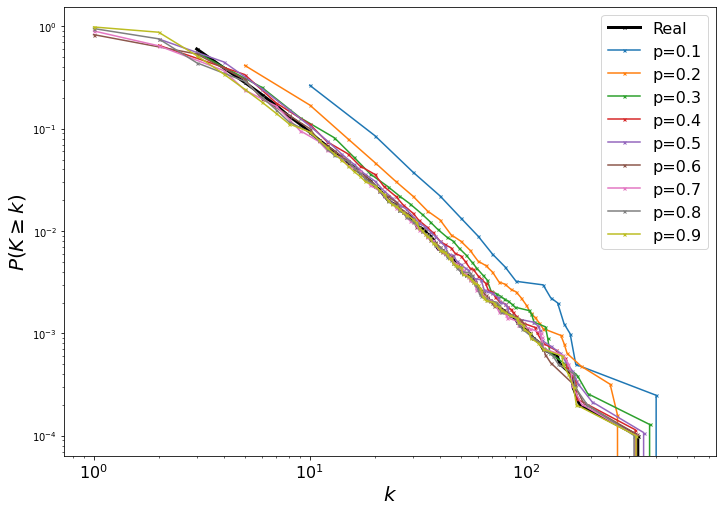

In [6]:
prange = np.linspace(0.1,0.9,9)
edges = G.edges()

fig, ax = setup_axes('$k$','$P(K\\geq k)$','log','log')

degs, cdf = get_deg_cdf(G)
ccdf = 1 - cdf/cdf[-1]
ax.plot(degs, ccdf,marker='x',markersize=3,label="Real", linewidth=3, color="black")

for p in prange:
    H = edge_sample(G,p)
    degrees = [d for n,d in nx.degree(H)]
    rescaled = sorted([math.floor(d/p) for d in degrees])
    degs, cdf = ecdf(rescaled)
#     cts = Counter(rescaled)
#     degs = sorted(cts.keys())
#     vals = [cts[val] for val in degs]
#     cdf = np.cumsum(vals)
    ccdf = cdf[-1] - cdf
    ccdf = 1-cdf/cdf[-1]
    ax.plot(degs, ccdf,marker='x',markersize=3,label="p="+str(round(p,1)))
    
ax.legend(fontsize=16)
plt.show()

Too harsh to use this MLE. For example, no degrees possible in range (0, 1/p). Try relax this to find an estimator for k_i using likelihood.

## Triangle Count

Here we look at triangles, wedges and global clustering coefficient, finding scale-up estimates of these.

In [133]:
def triangles(n1, n2, G):
    if not G.has_edge(n1,n2):
        return 0
    else:
        return len(list(nx.common_neighbors(G,n1,n2)))
    
def edge_triangle_count(G):
    tc = []
    for i in G.nodes():
        for j in G.neighbors(i):
            if i>j:
                continue
            tc.append(triangles(i,j,G))
    return tc

def common_neighbours(n1, n2, G):
    n1neigh = set(G.neighbors(n1))
    n2neigh = set(G.neighbors(n2))
    return len(n1neigh.intersection(n2neigh)), G.has_edge(n1,n2)

def local_wedge_count(G):
    nodes = sorted(G.nodes())
    ec = []
    for i in range(len(nodes)):
        for j in range(i):
            cn = common_neighbours(nodes[i],nodes[j],G)
            if cn[0]!=0:
                ec.append(cn[0])
    return ec

def wedge_count(G):
    return 0.5*sum([d*(d-1) for n,d in G.degree()])

def scaleup_triangle_count(tri_array, p):
    return [round(1.0/p**3*ct) for ct in tri_array]

def scaleup_wedge(H,p):
    return 1.0/p**2*wedge_count(H)

def scaleup_local_wedge(H,p):
    return 1.0/p**2*np.array(H)

def scaleup_clustering_coeff(H,p):
    wc = 1.0/p**2*wedge_count(H)
    t_array = scaleup_triangle_count(edge_triangle_count(H),p)
    tc = sum(t_array)
    return t_array/wc

def tot_tri_estimate(H,p):
    tri_array = edge_triangle_count(H)/p**3
    return sum(tri_array)

def triangle_likelihood(t,tc,p):
    return math.comb(t,tc)*math.pow(p*p,(tc))*math.pow((1.0-p*p),(t-tc))


0.15278490332744976


## Edge triangle count distribution scale-up

122852.0
143000.0
121875.0
123284.0
124272.0
125928.0
125248.0
124949.33333333333
125522.33333333333
118531.0


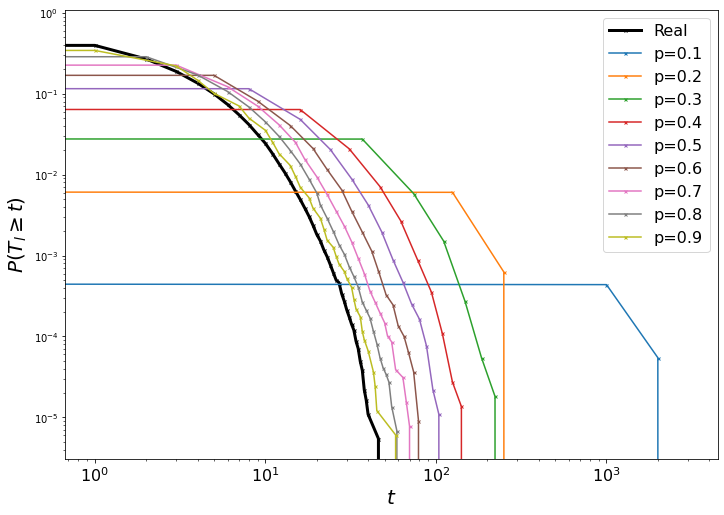

In [30]:
fig, ax = setup_axes('$t$','$P(T_l\\geq t)$','log','log')
# G = nx.barabasi_albert_graph(10000,3)
fname="/Users/naomiarnold/CODE/NaomiFETA/FETA3.1/experiments/facebook/facebook.dat"
net = pd.read_csv(fname,sep=" ",names=["source","target","t"])
net = net.drop(["t"], axis=1)
G = nx.from_pandas_edgelist(net)

tc = edge_triangle_count(G)
print(sum(tc)/3.0)
tri, cdf = ecdf(tc)
ccdf = 1 - cdf/cdf[-1]

ax.plot(tri, ccdf,marker='x',markersize=3,label="Real", linewidth=3, color="black")

prange = np.linspace(0.1,0.9,9)

for p in prange:
    H = edge_sample(G,p)
    tc_sampled = edge_triangle_count(H)
    tc_estimate = scaleup_triangle_count(tc_sampled,p)
    print(sum(tc_estimate)/3.0)
    tri, cdf = ecdf(tc_estimate)
    ccdf = 1 - cdf/cdf[-1]
    ax.plot(tri, ccdf,marker='x',markersize=3,label="p="+str(round(p,1)))
    
ax.legend(fontsize=16)
plt.show()

202699.99999999997
201474.99999999997
189500.0000000495
191949.99999999997
190248.0
189419.44444461644
196467.34693877507
190757.81249999997
194216.04938291115


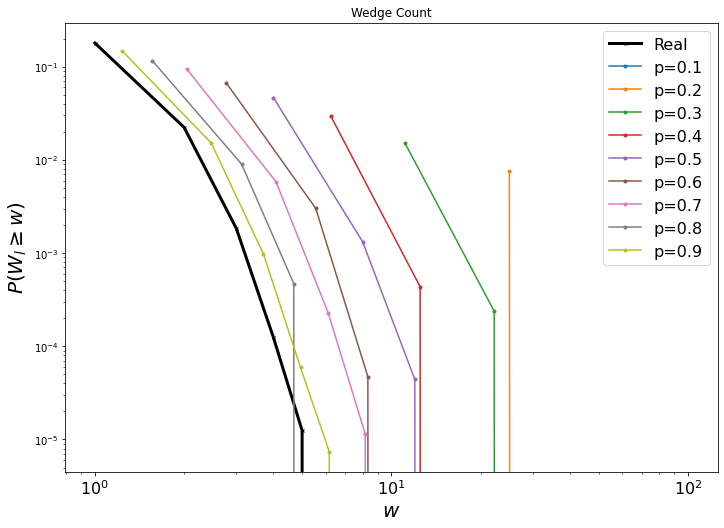

In [29]:
fig, ax = setup_axes('$w$','$P(W_l\\geq w)$','log','log')
G = nx.gnp_random_graph(1000,0.02)
# fname="/Users/naomiarnold/CODE/NaomiFETA/FETA3.1/experiments/facebook/facebook.dat"
# net = pd.read_csv(fname,sep=" ",names=["source","target","t"])
# net = net.drop(["t"], axis=1)
# G = nx.from_pandas_edgelist(net)

ec = local_wedge_count(G)
tri, cdf = ecdf(ec)
ccdf = 1 - cdf/cdf[-1]

ax.plot(tri, ccdf,marker='x',markersize=3,label="Real", linewidth=3, color="black")
ax.set_title("Wedge Count")
prange = np.linspace(0.1,0.9,9)

for p in prange:
    H = edge_sample(G,p)
    ec_sampled = local_wedge_count(H)
    ec_estimate = scaleup_local_wedge(ec_sampled,p)
    print(sum(ec_estimate))
    #print(sum([x[0] for x in ec_estimate])/3.0)
    tri, cdf = ecdf(ec_estimate)
    ccdf = 1 - cdf/cdf[-1]
    ax.plot(tri, ccdf,marker='o',markersize=3,label="p="+str(round(p,1)))
    
ax.legend(fontsize=16)
plt.show()

## Clustering coefficient scale-up experiment

In [93]:
fname="/Users/narnolddd/CODE/FETA/FETA3/data/sx_reordered.txt"
net = pd.read_csv(fname,sep=" ",names=["source","target","t"])
net = net.drop(["t"], axis=1)
G = nx.from_pandas_edgelist(net)

# tc = edge_triangle_count(G)
# tri, cdf = ecdf(tc)
# ccdf = 1 - cdf/cdf[-1]

experiments = 10
guesses = np.zeros((experiments, len(prange)))
cc_guesses=np.zeros((experiments, len(prange)))
for ex in range(experiments):
    print(ex+1)
    H = [edge_sample(G,p) for p in prange]
    tc_estimate = np.array(list(map(lambda x: tot_tri_estimate(H[x],prange[x]),range(9))))
    guesses[ex,:] = tc_estimate
    wc_estimate = np.array(list(map(lambda x: MME_wedge(H[x],prange[x]),range(9))))
    cc_guesses[ex,:] = tc_estimate/wc_estimate

1
2
3
4
5
6
7
8
9
10


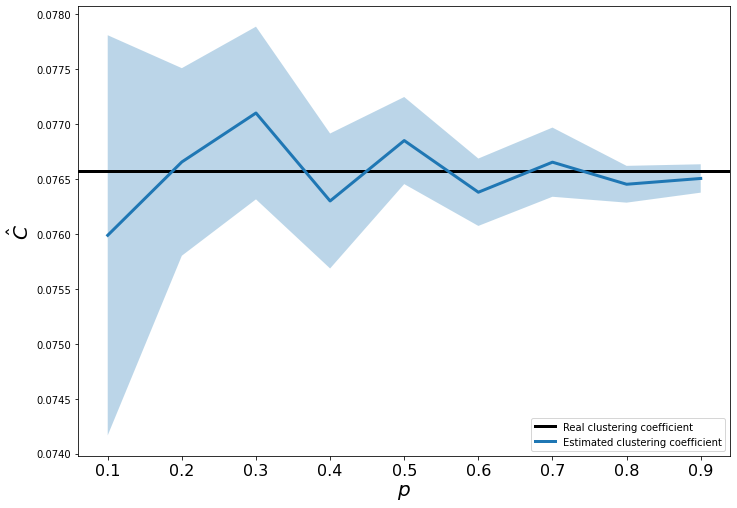

In [94]:
fig, ax = setup_axes('$p$','$\\hat{C}$','linear','linear')

tc = edge_triangle_count(G)
wc = wedge_count(G)
ax.axhline(sum(tc)/wc, color="black", linewidth=3,label="Real clustering coefficient")

means = np.mean(cc_guesses,axis=0)
stds = np.std(cc_guesses,axis=0)

df = pd.DataFrame(cc_guesses)
df.to_csv("sx_cluster.csv")
means = np.mean(cc_guesses,axis=0)
stds = np.std(cc_guesses,axis=0)

ax.plot(prange,means,label="Estimated clustering coefficient",linewidth=3)
ax.fill_between(prange,means-0.5*stds,means+0.5*stds,alpha=0.3)
plt.legend(loc = "lower right")
plt.savefig("sx_clustering.pdf")
plt.show()

In [11]:
def total_triangle_experiment(G, experiments, fname):
    tc = edge_triangle_count(G)
    tri, cdf = ecdf(tc)
    ccdf = 1 - cdf/cdf[-1]

    prange = np.linspace(0.1,0.9,9)
    guesses = np.zeros((experiments, len(prange)))
    
    for ex in range(experiments):
        guesses[ex,:] = np.array(list(map(lambda x: tot_tri_estimate(G,x),prange)))
        
    means = np.mean(guesses,axis=0)
    stds = np.std(guesses,axis=0)

    df = pd.DataFrame(guesses)
    df.to_csv(fname)
    means = np.mean(guesses,axis=0)
    stds = np.std(guesses,axis=0)
    
    return means, sds

## Posterior estimates for triangle count

In [8]:
from collections import defaultdict

In [124]:
n = 1000
m = 10000
seed = 101  # seed random number generators for reproducibility
p=0.5

## Use seed for reproducibility
#G = nx.gnm_random_graph(n, m, seed=seed)
G = nx.gnm_random_graph(n, m,seed)

tc = edge_triangle_count(G)
tri, cdf = ecdf(tc)

num_tri = sum(nx.triangles(G).values()) / 3
print("Tri:",num_tri)
removeList=[]
tCount={}
for u,v,a in G.edges(data=True):
    if (random.random()) >= p:
        removeList.append((u,v))
    tc= triangles(u,v,G)
    if tc in tCount:
        tCount[tc]= tCount[tc]+1.0
    else:
        tCount[tc]= 1.0

maxT=0
for t in tCount:
    tCount[t]= tCount[t]/len(G.edges)
    if t > maxT:
        maxT= t


#print("Sum=",sumt,tCount)
G2= G.copy()
for e in removeList:
    G2.remove_edge(e[0],e[1])
tCount2={}
for u,v,a in G.edges(data=True):
    tc= triangles(u,v,G2)
    if tc in tCount2:
        tCount2[tc]= tCount2[tc]+1.0
    else:
        tCount2[tc]= 1.0
for t in tCount2:
    tCount2[t]= tCount2[t]/len(G.edges)
print(tCount2)
num_tri = sum(nx.triangles(G2).values()) / 3
T_lambda = 3 * num_tri/( p**3 * m)

#print("Tri maxT:",num_tri, maxT)

ElTot= 0.0
zcount=0.0
test= 0.0
tsampest= 0.0
for t in tCount:
    test+= t*tCount[t]*len(G.edges)
    try:
        tsampest+= t*tCount2[t]*len(G.edges)
    except:
        pass
print ("Test = ",test/3.0," Tsampest=",tsampest/3.0)
print(tCount)
for u,v,a in G.edges(data=True):
    tc= triangles(u,v,G2)
    toc= triangles(u,v,G)
    zcount+=math.pow((1.0-p*p*p),toc)
    den=0.0
    num=0.0
    for t in range(tc,maxT+1):
        fact= math.comb(t,tc)*math.pow(p*p,(tc))*math.pow((1.0-p*p),(t-tc))*tCount[t]
        num+= t*fact
        den=tCount2[tc]
        # if tc > 0:
            # fact= math.comb(t,tc)*math.pow(p*p,(tc))*math.pow((1.0-p*p),(t-tc))*tCount[t]
            # num+= t*fact
            # den=tCount2[tc]
        # else:
            # num+= t*((1.0-p)+p*math.pow(1.0-p*p,t))*tCount[t]
            # den=tCount2[0]

    ElTot+=num/den
    
est_tri, est_cdf = ecdf()
print("Zcount=",zcount,"Zprop=",zcount/len(G.edges))
print("ElTot=", ElTot/3)
print("Tri /p^3=", num_tri/(p*p*p))

Tri: 1343.0
{0: 0.9534, 1: 0.0446, 2: 0.002}
Test =  1343.0  Tsampest= 162.0
{0: 0.6655, 1: 0.2745, 3: 0.007, 2: 0.0523, 4: 0.0007}
Zcount= 9508.294677734375 Zprop= 0.9508294677734375
ElTot= 1341.4322916663402
Tri /p^3= 1296.0


In [152]:
n, m, p, seed = 1000, 25000, 0.5, 101

G = nx.gnm_random_graph(n, m,seed)
#G = nx.barabasi_albert_graph(n,10,seed)
H = edge_sample(G,p)
m = len(H.edges())

# estimated number of edges that were removed by the sampling procedure
edges_estimated = m**2/(p*(m + 1-p)) + (1-p)/p
missing_edges = edges_estimated - len(H.edges())
removed_edges = len(G.edges()) - len(H.edges())
print("Estimated edges removed: ",missing_edges)
print("Actual edges removed: ",removed_edges)

# get triangle count of real and sampled graph
tl_real = edge_triangle_count(G)
T_real = sum(tl_real)/3.0
tl_sampled = edge_triangle_count(H)
T_sampled = sum(tl_sampled)/3.0

tri, cdf = ecdf(tl_real)
ccdf = 1 - cdf/cdf[-1]

# simple p3 estimate
T_estimated = T_sampled/p**3

# average edge triangle count estimated 
#T_lambda = T_estimated*3.0/(len(H.edges()))
T_lambda = T_estimated*3.0/(len(H.edges())+removed_edges)
wedge_lambda = 2*wedge_count(H)/(len(H.nodes())*(len(H.nodes())-1))

# Fill in gaps for the missing edges
tl_sampled += [0 for _ in range(removed_edges)]

print("Total Triangles: ",T_real)

print("p cubed estimate: ",T_estimated)

tl_prop, tl_sample_prop = count2freq(tl_real), count2freq(tl_sampled)

assert abs(sum(tl_prop.values())-1.0) <0.00001, "oh no "+str(sum(tl_prop.values()))
assert abs(sum(tl_sample_prop.values()) - 1.0) <0.0001, "oh no "+str(sum(t1_sample_prop.values()))

maxT=0
while poisson.cdf(maxT,T_lambda)<0.9999:
    maxT+=1

print("Maximum T: ",max(tl_real))
print("99.99th poisson percentile: ",maxT)

prob_caches={}

tl_est = []
for el in tl_sampled:
    den = tl_sample_prop[el]
    #den=0.0
    num = 0.0
    argmax = 0.0
    for t in range(el, maxT+1):
        if (t,el) not in prob_caches:
            prob_caches[(t,el)]= triangle_likelihood(t,el,p) * poisson.pmf(t,T_lambda)
        fact = prob_caches[(t,el)]
        #fact = triangle_likelihood(t,el,p) * tl_prop[t]
        num+= t*fact
        #den+= fact
    tl_est.append(num/den)
    
tc_estimate = scaleup_triangle_count(tl_sampled,p)
tri_crude, cdf_crude = ecdf(tc_estimate)
ccdf_crude = 1 - cdf_crude/cdf_crude[-1]
    
tri_est, cdf_est = ecdf(tl_est)
ccdf_est = 1 - cdf_est/cdf_est[-1]
T_post = sum(tl_est)/3.0
    
print("Posterior estimate: ",T_post)

Estimated edges removed:  12492.000040024013
Actual edges removed:  12508
Total Triangles:  20785.0
p cubed estimate:  20600.0
Maximum T:  10
99.99th poisson percentile:  12
Posterior estimate:  20596.761181056412


[ 1.30007943  5.65224795  7.80898966  9.58600166 10.08998391 23.09723478]


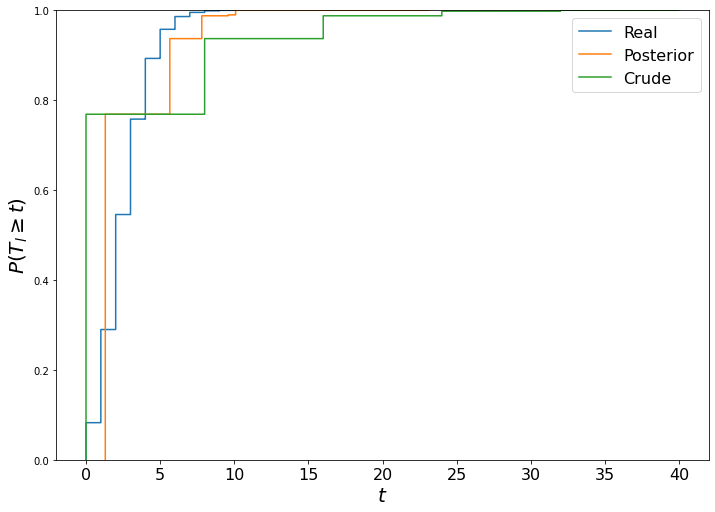

In [156]:
fig, ax = setup_axes('$t$','$P(T_l\\geq t)$','linear','linear')

# ax.plot(tri, ccdf,marker='x',markersize=3,label="Real", linewidth=3, color="black")
# ax.plot(tri_est, ccdf_est,marker='x',markersize=3,label="Posterior", linewidth=3, color="blue")
# ax.plot(tri_crude, ccdf_crude,marker='x',markersize=3,label="Crude",linewidth=3,color="red")

sns.ecdfplot(tl_real,label="Real")
sns.ecdfplot(tl_est,label="Posterior")
sns.ecdfplot(tc_estimate,label="Crude")

print(tri_est)

ax.legend(fontsize=16)
plt.show()

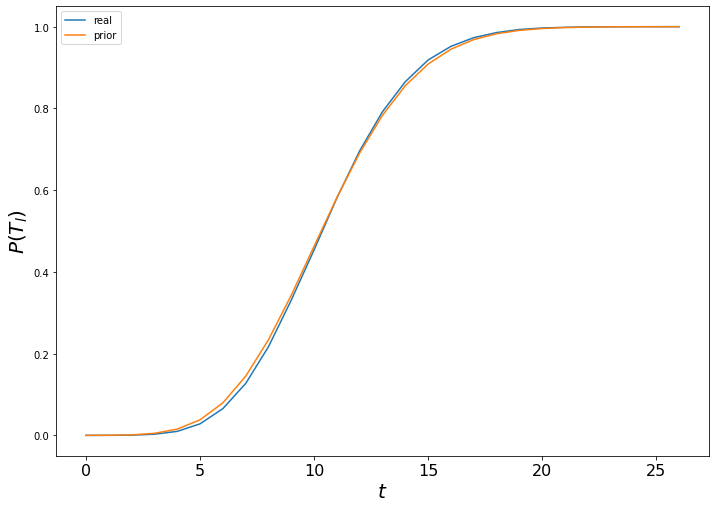

4.6465788954144416e-05


In [93]:
fig, ax = setup_axes('$t$','$P(T_l)$','linear','linear')

x=range(27)
y1 = [poisson.cdf(t,T_lambda+1) for t in x]
y2 = [sum([tl_prop[t] for t in range(z)]) for z in x]
y3 = [sum([tl_sample_prop[t] for t in range(z)]) for z in x]

#ax.plot(y3,label="observed")
ax.plot(y2,label="real")
ax.plot(y1,label="prior")

ax.legend()
plt.show()

print(poisson.pmf(0,T_lambda))

## Posterior sampling approach


In [97]:
from math import comb

def binom_prob(k,kp,p):
    if k < kp:
        return 0.0
    return comb(k,kp) * np.power(p,kp) *np.power(1-p,k-kp)

# not the bayesian approach
def gen_distribution(k,p,kmax):
    probs = np.zeros(kmax+1)
    for deg in range(k,kmax + 1):
        probs[deg] = binom_prob(k,deg,p)
    return probs/np.sum(probs)

def posterior_exp(kp, p, prior, likelihood):
    summand = np.array(range(kp,len(prior)))
    f1 = lambda k: k*likelihood(k)*prior[k]
    return sum([f1(s) for s in summand])

# Returns posterior probability but NOT NORMALISED
def posterior_prob(kp, p, prior, likelihood):
    summand = np.array(range(kp,len(prior)))
    f1 = lambda k: likelihood(k)*prior[k]
    return sum([f1(s) for s in summand])

def normalisation(kp,observed):
    return observed[kp]

# Returns posterior estimate sum but NOT NORMALISED
def degree_posterior_exp(kp,prior,observed,p):
    f1 = lambda k: binom_prob(kp,k,p)
    return posterior_exp(kp,p,prior,f1)/observed[kp]


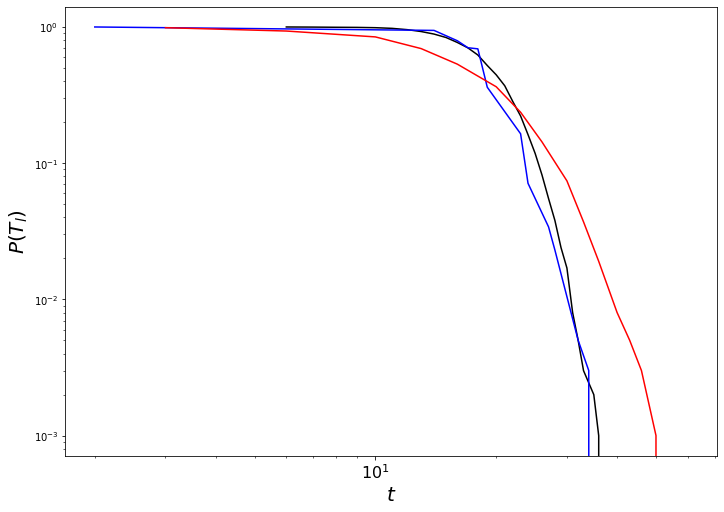

In [113]:
n, m, p, seed = 1000, 10000, 0.3, 101

G = nx.gnm_random_graph(n, m,seed)
#G = nx.barabasi_albert_graph(n,10,seed)
H = edge_sample(G,p)

# estimated number of edges that were removed by the sampling procedure
edges_estimated = int(1.0/p * len(H.edges()))
missing_edges = edges_estimated - len(H.edges())
removed_edges = len(G.edges()) - len(H.edges())

ki = [d for n, d in G.degree()]
ki_sampled = [d for n,d in H.degree()]
ki_mme = [int(d/p) for n,d in H.degree()]
kmax=max(ki)

pk = count2freq(ki)
pk_sampled = count2freq(ki_sampled)

ki_est=[]
for kp in ki_sampled:
    den = 0.0
    num = 0.0
    den=pk_sampled[kp]
    for k in range(kp, kmax+1):
        fact = binom_prob(k,kp,p) * pk[k]
        num+= k*fact
        #den+= fact
    ki_est.append(round(num/den))
    
deg, cdf = ecdf(ki)
ccdf = 1 - cdf/cdf[-1]
deg2, cdf2 = ecdf(ki_est)
ccdf2 = 1 - cdf2/cdf2[-1]
deg3, cdf3 = ecdf(ki_mme)
ccdf3 = 1 - cdf3/cdf3[-1]

fig, ax = setup_axes('$t$','$P(T_l)$','log','log')

ax.plot(deg,ccdf,color="black")
ax.plot(deg2, ccdf2, color="blue")
ax.plot(deg3, ccdf3, color="red")

plt.show()

In [103]:
#G=nx.gnp_random_graph(1000,0.01)
G=nx.gnp_random_graph(10000,0.001)

p=0.5
H = edge_sample(G,p)
degrees = [d for n,d in nx.degree(H)]
mme_degrees = np.array([round(d/p) for n,d in nx.degree(H)])
prior = np.zeros(max(mme_degrees)+1)

for d in mme_degrees:
    prior[d]+=1.0
prior/=sum(prior)

observed = np.zeros(max(degrees)+1)
for d in degrees:
    observed[d]+=1.0
observed/=sum(observed)

deg_sequence = [degree_posterior_exp(kp,prior,observed,p) for kp in degrees]

In [76]:
prior = np.zeros(math.ceil(max(deg_sequence))+1)
for d in deg_sequence:
    prior[int(d)]+=1.0
prior/=sum(prior)
    
deg_sequence = [degree_posterior_exp(kp,prior,observed,p) for kp in degrees]

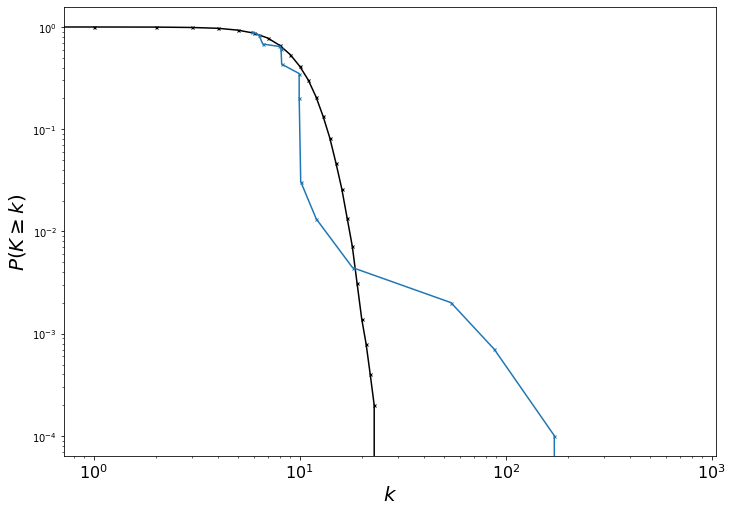

In [75]:
fig, ax = setup_axes('$k$','$P(K\\geq k)$','log','log')

rdegs, rcdf = get_deg_cdf(G)
rcdf = 1 - rcdf/rcdf[-1]
degs, cdf = ecdf(deg_sequence)
ccdf = 1 - cdf/cdf[-1]

ax.plot(rdegs, rcdf,marker='x',markersize=3,label="real",color='black')
ax.plot(degs, ccdf,marker='x',markersize=3,label="p="+str(0.8))

In [12]:
def sample(dist):
    r = random.random()
    tot = 0.0
    ind = 0
    while tot < r:
        tot += dist[ind]
        ind +=1
    return ind

In [13]:
def est_dist(degs,freqs,p,n):
    isolates = n - sum(freqs)
    newdegs = []
    degs.append(0)
    freqs.append(isolates)
    for i in range(len(degs)):
        k = int(degs[i])
        kmax = int(1/p * k +1)
        fr = freqs[i]
        dist = gen_distribution(k,p,kmax)
        for _ in range(fr):
            newdegs.append(sample(dist))
    return newdegs

In [32]:
#G = nx.barabasi_albert_graph(10000,3)
G = nx.gnp_random_graph(10000,0.001)
p=0.2
H = edge_sample(G,p)
c = Counter([d for n,d in H.degree()])
degs = sorted(c.keys())
vals = [c[val] for val in degs]

newdegs = est_dist(degs,vals,p,len(G.nodes()))

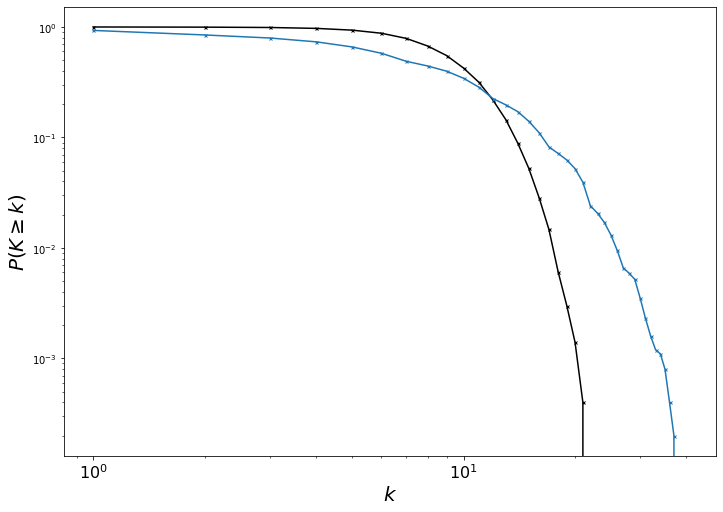

In [33]:
fig, ax = setup_axes('$k$','$P(K\\geq k)$','log','log')
rdegs, rcdf = get_deg_cdf(G)
rcdf = 1 - rcdf/rcdf[-1]
degs, cdf = ecdf(newdegs)
ccdf = 1 - cdf/cdf[-1]

ax.plot(rdegs, rcdf,marker='x',markersize=3,label="real",color='black')
ax.plot(degs, ccdf,marker='x',markersize=3,label="p="+str(0.8))

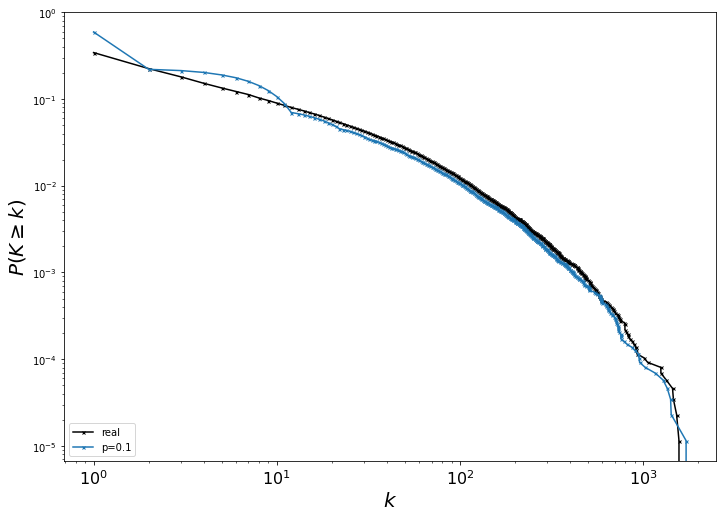

In [103]:
fname="/Users/narnolddd/CODE/FETA/FETA3/data/enron.dat"
net = pd.read_csv(fname,sep=" ",names=["source","target","t"])
net = net.drop(["t"], axis=1)
G = nx.from_pandas_edgelist(net)

p=0.1
H = edge_sample(G,p)
c = Counter([d for n,d in H.degree()])
degs = sorted(c.keys())
vals = [c[val] for val in degs]

newdegs = est_dist(degs,vals,p,len(G.nodes()))

fig, ax = setup_axes('$k$','$P(K\\geq k)$','log','log')
rdegs, rcdf = get_deg_cdf(G)
#rcdf = rcdf[-1] - rcdf
rcdf = 1 - rcdf/rcdf[-1]

degs, cdf = ecdf(newdegs)
#ccdf = cdf[-1] - cdf
ccdf = 1 - cdf/cdf[-1]

ax.plot(rdegs, rcdf,marker='x',markersize=3,label="real",color='black')
ax.plot(degs, ccdf,marker='x',markersize=3,label="p="+str(p))
ax.legend(loc="lower left")
plt.show()

In [4]:
kp = 1
p = 0.1
kmax = kp/p

num = sum([k*comb(k,kp)*np.power(1-p,k) for k in range(kp,int(kmax+1))])
den = sum([comb(k,kp)*np.power(1-p,k) for k in range(kp,int(kmax+1))])

print(num/den)

6.326779992108712
